In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from qiskit.circuit import ClassicalRegister, QuantumRegister, Parameter
from qiskit import QuantumCircuit


List of algorithms in this notebook:
*   Teleportation
*   Grover (n=2, n=3)
*   Dense coding
*   Deutsch-Jorza
*   QFT

## Teleportation

In [2]:
def teleportation(theta):
    #Define the control circuit
    qr = QuantumRegister(1, 'q')        #Define a quantum register named "q"
    control_qc = QuantumCircuit(qr)

    control_qc.ry(theta, 0)             #Rotate qubit 0 with theta

    tele_qc = control_qc.copy()                     #Copy of a circuit
    bell = QuantumRegister(2, 'Bell')
    alice = ClassicalRegister(2, 'Alice')           #Define a classical register named "Alice"
    bob = ClassicalRegister(1, 'Bob')
    tele_qc.add_register(bell, alice, bob)          #Add registers to the circuit

    #Bell state
    tele_qc.h(1)
    tele_qc.cx(1, 2)

    #Alice's operations
    tele_qc.cx(0, 1)
    tele_qc.h(0)

    #Alice's measurements
    tele_qc.barrier()
    tele_qc.measure([qr[0], bell[0]], alice)


    #If condition: operations based on measure
    tele_qc.x(2).c_if(alice[1], 1)
    tele_qc.z(2).c_if(alice[0], 1)

    #Bob's measurement
    tele_qc.barrier()
    tele_qc.measure(bell[1], bob)

    #Measure control circuit
    control_qc.measure_all()

    return control_qc, tele_qc

In [3]:
#Define a parameter
theta = Parameter(r"$\theta$") 

#Save the circuits     
control_qc, tele_qc = teleportation(theta)

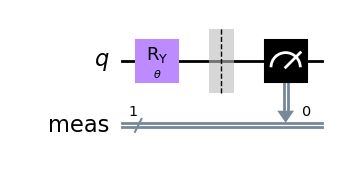

In [4]:
control_qc.draw("mpl")

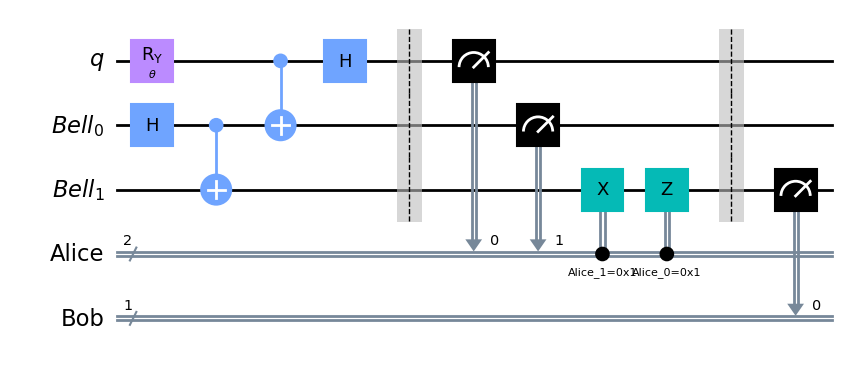

In [5]:
tele_qc.draw("mpl")

Original Dists: {'1': 619, '0': 405}
Teleported Dists: {'1 01': 168, '1 11': 154, '0 00': 91, '1 10': 163, '1 00': 155, '0 11': 100, '0 10': 92, '0 01': 101}
Result(backend_name='qasm_simulator', backend_version='2.1.0', qobj_id='83556b4b-9163-4bff-a30b-cabe8a510b4a', job_id='8c005c6f-c6f7-4447-bd0c-36b0d59da63a', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1': 640, '0x0': 384}), header=QobjExperimentHeader(qubit_labels=[['q', 0], ['Bell', 0], ['Bell', 1]], n_qubits=3, qreg_sizes=[['q', 1], ['Bell', 2]], clbit_labels=[['Alice', 0], ['Alice', 1], ['Bob', 0]], memory_slots=1, creg_sizes=[['Bob', 1]], name='circuit-121', global_phase=0.0, metadata={}), status=DONE, name='circuit-121', seed_simulator=1184968183, time_taken=0.4374077320098877)], date=None, status=COMPLETED, header=QobjHeader(), time_taken=0.4374077320098877)


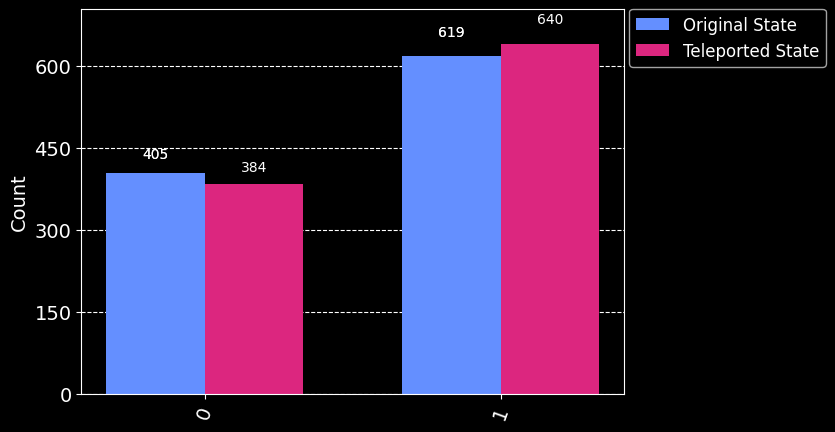

In [6]:
#Confront the results
angle = 4*np.pi/7       #Angle theta to get an arbitrary initial state

#Access to the simulation backend
from qiskit import BasicAer, assemble, transpile
backend = BasicAer.get_backend('qasm_simulator')    
#Get the results
result_original = backend.run(assemble(transpile(control_qc.bind_parameters({theta: angle}), backend))).result()
result_tele = backend.run(assemble(transpile(tele_qc.bind_parameters({theta: angle}), backend))).result()

print(f"Original Dists: {result_original.get_counts()}")
print(f"Teleported Dists: {result_tele.get_counts()}")

#Marginalization: from [Alice0Alice1Bob] to [Bob]
from qiskit.result import marginal_counts
tele_counts = marginal_counts(result_tele, [2]) #[2] to sum over [0, 1]
print(tele_counts)

#Visualize the counts
from qiskit.visualization import plot_histogram
legend = ['Original State', 'Teleported State']
plot_histogram([result_original.get_counts(), tele_counts.get_counts()], legend=legend)

## Grover

### 2 qubits

In [7]:
from qiskit.quantum_info.operators import Operator
from qiskit.visualization import array_to_latex

def oracle(x_tilde):
    #Note that the oracle include the phase-kickback of the ancilla qubit 
    if x_tilde == "00":
        Op = Operator([[-1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    if x_tilde == "01":
        Op = Operator([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    if x_tilde == "10":
        Op = Operator([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    if x_tilde == "11":
        Op = Operator([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, -1]])
    return Op

#Choose x_tilde
oracle_operator = oracle("01")
array_to_latex(oracle_operator)

<IPython.core.display.Latex object>

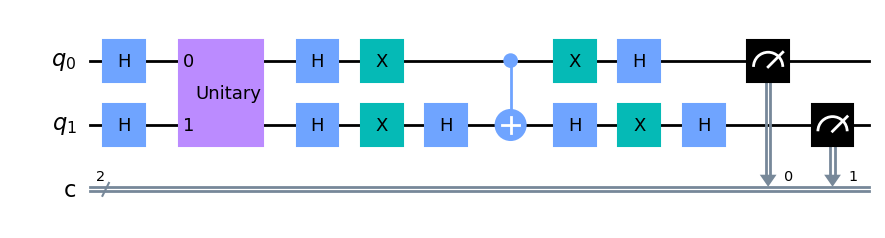

In [8]:
def grover(oracle_operator):
    qc = QuantumCircuit(2, 2)
    qc.h([0, 1])
    qc.append(oracle_operator, [0, 1])
    
    qc.h([0, 1])
    qc.x([0, 1])
    qc.h(1)
    qc.cx(0, 1)
    qc.h(1)
    qc.x([0, 1])
    qc.h([0, 1])
    
    qc.measure([0,1], [0,1])

    return qc

qc = grover(oracle_operator)
qc.draw("mpl")

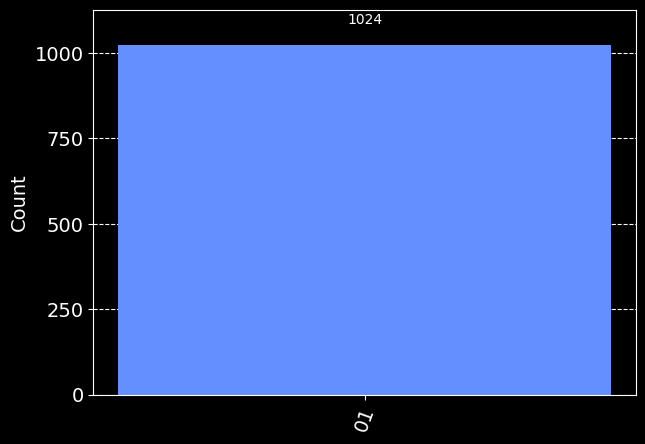

In [9]:
from qiskit import BasicAer, assemble, transpile
backend = BasicAer.get_backend('qasm_simulator')    

result = backend.run(assemble(transpile(qc, backend=backend), backend)).result()
plot_histogram(result.get_counts())

### 3 qubits

In [10]:
np.identity(8)

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [11]:
def oracle(x_tilde):
    #Note that the oracle include the phase-kickback of the ancilla qubit 
    matrix = np.identity(8)
    if x_tilde == "000":
        matrix[0, 0] = -1
    if x_tilde == "001":
        matrix[1, 1] = -1
    if x_tilde == "010":
        matrix[2, 2] = -1
    if x_tilde == "011":
        matrix[3, 3] = -1
    if x_tilde == "100":
        matrix[4, 4] = -1
    if x_tilde == "101":
        matrix[5, 5] = -1
    if x_tilde == "110":
        matrix[6, 6] = -1
    if x_tilde == "111":
        matrix[7, 7] = -1
    
    return Operator(matrix)

In [12]:
#Choose x_tilde
oracle_operator = oracle("011")
array_to_latex(oracle_operator)

<IPython.core.display.Latex object>

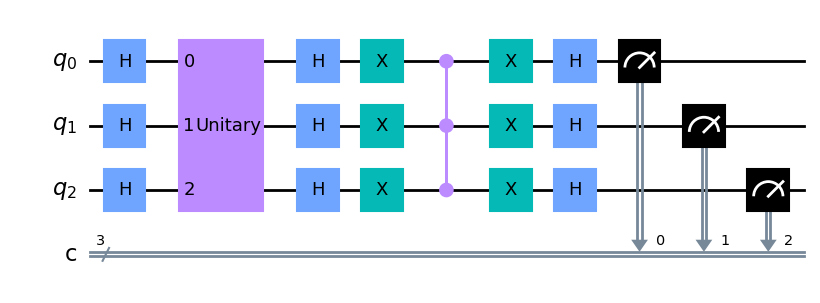

In [13]:
def grover(oracle_operator):
    qc = QuantumCircuit(3, 3)
    qc.h([0, 1, 2])
    qc.append(oracle_operator, [0, 1, 2])
    
    qc.h([0, 1, 2])
    qc.x([0, 1, 2])
    qc.ccz(1, 2, 0)
    qc.x([0, 1, 2])
    qc.h([0, 1, 2])
    
    qc.measure([0, 1, 2], [0, 1, 2])

    return qc

qc = grover(oracle_operator)
qc.draw("mpl")

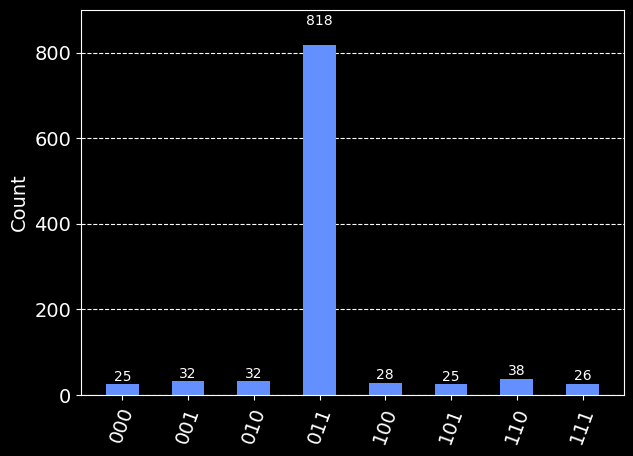

In [40]:
from qiskit import BasicAer, assemble, transpile
backend = BasicAer.get_backend('qasm_simulator')    

result = backend.run(assemble(transpile(qc, backend=backend), backend)).result()
plot_histogram(result.get_counts())

## Dense coding

In [69]:
from qiskit.quantum_info.operators import Operator, Pauli

def unitary_operation(bits):
    if bits == "00": 
        Op = Operator(Pauli("I"))
    if bits == "01": 
        Op = Operator(Pauli("Z"))
    if bits == "10": 
        Op = Operator(Pauli("X"))
    if bits == "11": 
        Op = Operator(Pauli("Y"))
    return Op

#Alice choice
operator = unitary_operation("01")

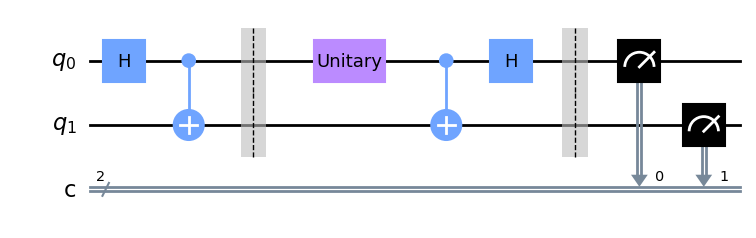

In [70]:
def dense(operator):
    qc = QuantumCircuit(2, 2)   #QuantumCircuit(QuantumRegister(4), ClassicalRegister(3))
    qc.h(0)                     #Apply an Hadamard gate to qubit 0
    qc.cx(0, 1)                 #Apply a CNOT (controlled by qubit 0)
    qc.barrier()

    qc.append(operator, [0])    #Apply a NOT (Alice operations in dense coding)
    qc.cx(0, 1)
    qc.h(0)
    qc.barrier()
    
    qc.measure([0, 1], [0, 1])
    return qc

qc = dense(operator)
qc.draw("mpl")

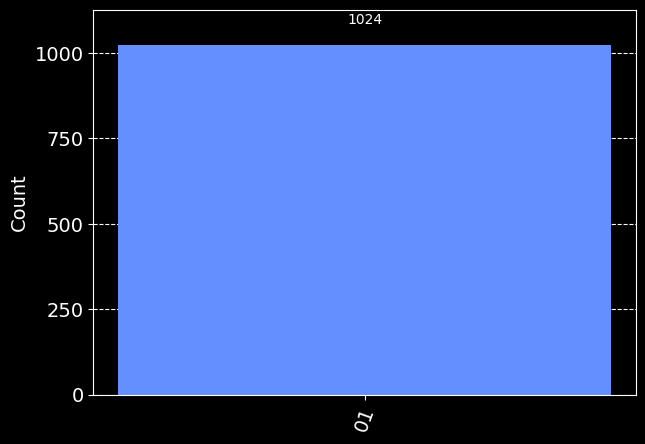

In [71]:
backend = BasicAer.get_backend('qasm_simulator')    

result = backend.run(assemble(transpile(qc, backend=backend), backend)).result()
plot_histogram(result.get_counts())

## Deutsch-Jorza

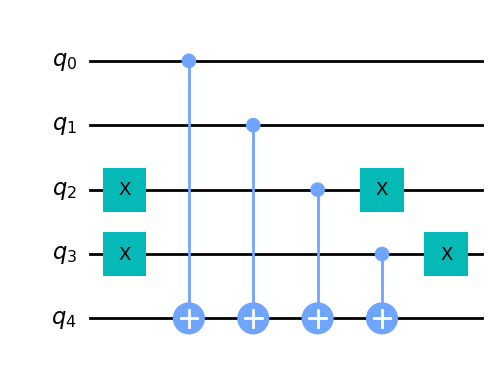

In [92]:
#An example of implementation of the oracle (from qiskit textbook)
def oracle(case, n):
    oracle_qc = QuantumCircuit(n+1)

    if case == "balanced":
        b = np.random.randint(1,2**n)
        b_str = format(b, '0'+str(n)+'b')
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    if case == "constant":
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle"

    #Return both gate and circuit
    return oracle_gate, oracle_qc

oracle("balanced", 4)[1].draw("mpl")

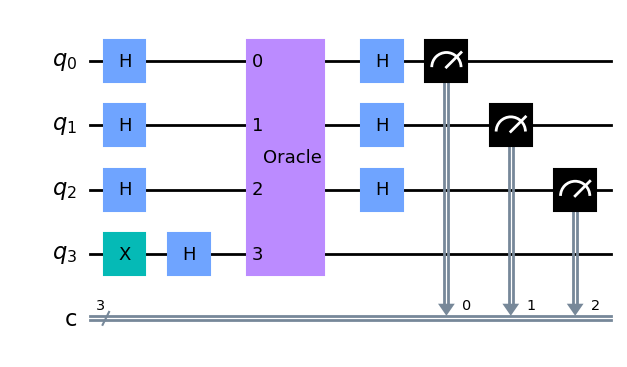

In [111]:
def deutsch_jorza(case, n):
    qc = QuantumCircuit(n+1, n)
    qc.x(n)
    qc.h(range(n+1))
    qc.append(oracle(case, n)[0], range(n+1))
    qc.h(range(n))
    qc.measure(range(n), range(n))

    return qc

qc = deutsch_jorza("balanced", 3)
qc.draw("mpl")

In [112]:
backend = BasicAer.get_backend('qasm_simulator')
result = backend.run(assemble(transpile(qc, backend=backend), backend)).result().get_counts()
print("Counts: " + str(result))

Counts: {'111': 1024}


## Quantum Fourier Transform

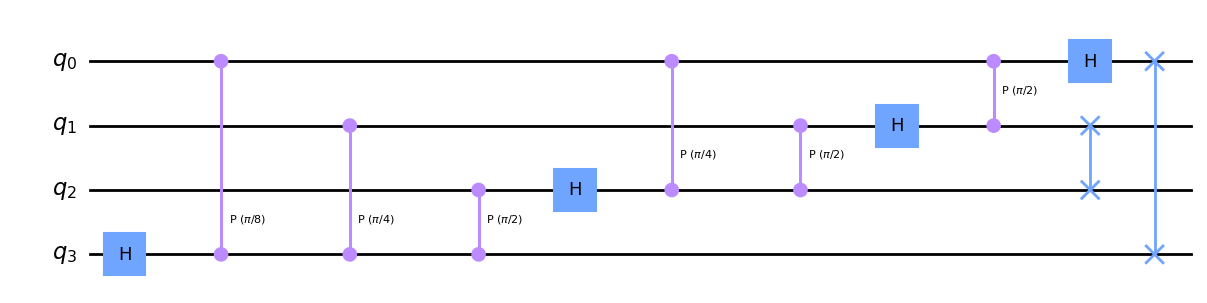

In [147]:
def qft(n):
    qc = QuantumCircuit(n)
    
    #QFT
    for i in range(n-1, -1, -1):
        qc.h(i)
        for j in range(n):
            if i>j:
                qc.cp(2*np.pi/2**(i+1-j) , j, i)
    
    #Swap qubits
    for i in range(n//2):
        qc.swap(i, n-i-1)

    return qc

qc = qft(4)
qc.draw("mpl")

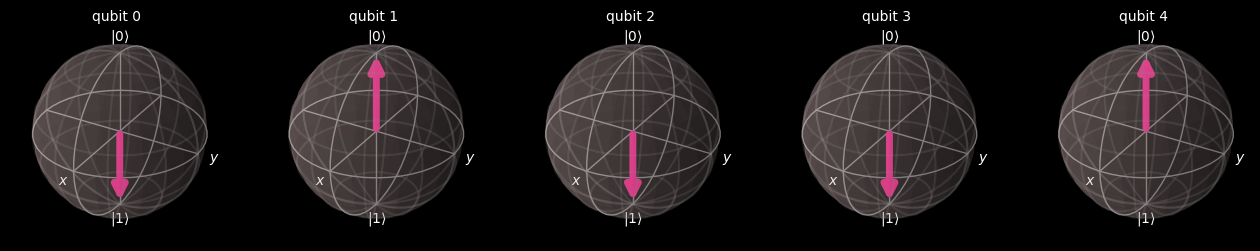

In [148]:
from qiskit.visualization import plot_bloch_multivector
init = QuantumCircuit(5, 5)
init.x([0, 2, 3])

from qiskit import execute
backend = BasicAer.get_backend('statevector_simulator')

#Plot initial state
init_statevector = Statevector(execute(init, backend).result().get_statevector())
plot_bloch_multivector(init_statevector)

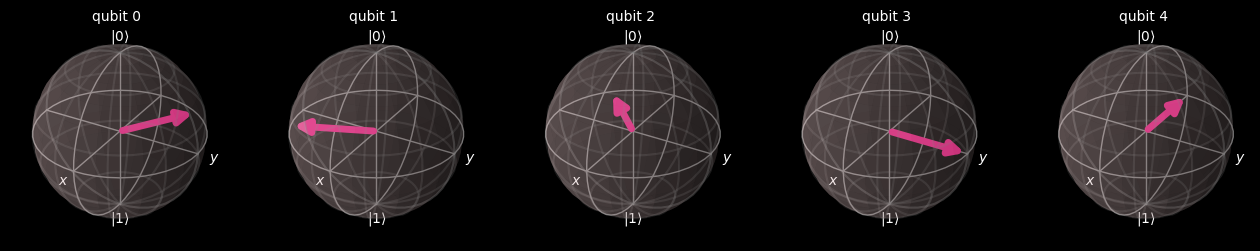

In [149]:
#Apply QFT
qft_gate = qft(5).to_gate()

qc = QuantumCircuit(5, 5)
qc.append(init, range(5), range(5))
qc.append(qft_gate, range(5))

backend = BasicAer.get_backend('statevector_simulator')
final_statevector = Statevector(execute(qc, backend).result().get_statevector())
plot_bloch_multivector(final_statevector)